# 💶 Food Affordability Analysis (2014–2024)

This notebook builds on the previous exploratory data analysis to assess the **affordability of food in Ireland** from 2014 to 2024.

**Affordability** in this project is defined as the ratio between the **cost of a standard monthly food basket** and **median monthly household income**. Allowing the observer to track how food prices, income levels, and external economic shocks (e.g. COVID-19, inflation, global conflicts) have affected the economic burden of maintaining a good diet over time.

---

## 🎯 Objectives of the Notebook

1. **Define** a standard, realistic food basket based on nutritional guidance and market availability.  
2. **Calculate** the monthly cost of this basket using standardized food prices.  
3. **Merge** this cost with household income data to measure affordability.  
4. **Create** an affordability index (baseline = 100 in 2014) to visualize trends.
5. **Draw insights** about economic pressure, policy relevance, and consumer impact.

---

### 📦 Data Sources

- `food_afford.csv`: Cleaned monthly food prices (€/kg or €/litre), 100% data coverage  
- `Households Annual Income.xlsx`: Median disposable household income in Ireland (CSO)  
- Basket and quantity definitions are based on FAO, HSE and SafeFood guidelines for a healthy diet.

---

📌 **Scope**: This analysis covers **monthly affordability** between **January 2014 and December 2024** and focuses on a working-age household aiming to eat nutritiously at minimum cost.

In [1]:
# 📦 Core Libraries for Data Analysis
import pandas as pd         # Data manipulation, cleaning, and analysis.
import numpy as np          # Numerical operations, arrays, statistics.

# 📊 Plotting Libraries
import matplotlib.pyplot as plt  # Basic plotting (line, histograms, bar charts).
import seaborn as sns            # Statistical visualizations (boxplots, heatmaps, KDEs).
import matplotlib.dates as mdates

# warnings: to suppress unnecessary warnings for cleaner notebook output.
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 📥 Section 1 – Data Loading and Validation

In this phase, the cleaned and pre-processed datasets are loaded:

- `food_afford.csv`: Cleaned food price data with standardized units and tagged nutritional categories.
- `Households Annual Income.xlsx`: Annual median household income in Ireland.

A quality check is performed to confirm:
- The `Date` column in the food data is parsed as a proper datetime format.
- Monthly and yearly indicators (`Year`, `Month`) are extracted for analysis.
- Household income is transformed to a **monthly income** column.
- The date ranges of both datasets are aligned.

In [2]:
# Load Cleaned & Tagged Food Data.
food = pd.read_csv("../data/food_afford.csv") 
# Ensure date column is datetime.
food['Date'] = pd.to_datetime(food['Date'])
food['Year'] = food['Date'].dt.year
food['Month'] = food['Date'].dt.month

# --------------------------------------------

# Load Household Income Data.
income = pd.read_excel("../data/Households Annual Income.xlsx")
# Confirms correct structure.
income.columns = ['Year', 'Median_Income_euro']
income['Monthly_Income'] = income['Median_Income_euro'] / 12

# --------------------------------------------

# Importing item_summary with the name item sum.
item_sum = pd.read_excel("../data/item_summary.xlsx")

# --------------------------------------------

# Quick Checks
print("Food Data Preview:\n", food.head(), "\n")
print("Income Data Preview:\n", income.head(), "\n")
print("Item Summary Preview:\n", item_sum.head(), "\n")

print(f"Food shape: {food.shape}")
print(f"Income shape: {income.shape}")
print(f"Date range: {food['Date'].min().date()} to {food['Date'].max().date()}")
print(f"Number of unique food items: {food['Item'].nunique()}")

Food Data Preview:
    Month                                   Item  Price_euro       Date  Year  \
0      1     White, self raising flour per 2 kg       2.308 2014-01-01  2014   
1      1        Brown, wholemeal flour per 2 kg       2.971 2014-01-01  2014   
2      1  Bread, white sliced pan, large (800g)       1.289 2014-01-01  2014   
3      1  Bread, brown sliced pan, large (800g)       1.532 2014-01-01  2014   
4      1                     Spaghetti per 500g       1.105 2014-01-01  2014   

   Month_num  conversion_factor  Price_per_kg_or_litre        Tag  \
0          1                0.5                 1.1540    Neutral   
1          1                0.5                 1.4855    Healthy   
2          1                1.0                 1.2890  Unhealthy   
3          1                1.0                 1.5320    Neutral   
4          1                2.0                 2.2100    Neutral   

                              Tag Source  is_outlier  
0       HSE: Flour-based, no 

📌 The food data spans from **January 2014 to May 2025**. However, the last record of income is in **2024**. Therefore, the food prices that are recorded in 2025 will be dropped to ensure alignment with the income dataset.

In [3]:
# Limit food data to match income year range
latest_year = income['Year'].max()
food = food[food['Year'] <= latest_year]
# Validating the new range.
print(f"Date range: {food['Date'].min().date()} to {food['Date'].max().date()}")

Date range: 2014-01-01 to 2024-12-01


## 🧺 Section 2 - Manual Food Basket Construction 

### Methodology & Justification Overview

To assess food affordability in a meaningful and realistic way, we construct a simplified, representative household food basket. This basket includes commonly consumed, nutritionally essential food items across key categories (protein, carbohydrates, dairy, vegetables, and fruits).

Each item is paired with a realistic estimated **monthly quantity per household**, based on public dietary guidelines, consumption patterns, and domain knowledge. The basket is used to compute a **monthly cost of eating a healthy, basic diet**.

#### Why Manual Selection and Not automatic? 

A fully data-driven basket (e.g., based on household budget microdata) is ideal but not always publicly available. In this project, a **manual informed approach** is applied to:

- Build a transparent and reproducible basket.
- Control for nutritional balance and affordability.
- Avoid distortion from rarely purchased or luxury foods.
- Reflect real-world trade-offs consumers face during economic pressure.

The final basket covers **essential, affordable, and accessible** items available in Ireland from 2014 to 2024. All steps taken in this project are backed by evidence, documented assumptions, and national dietary policy — ensuring the affordability model is realistic.

---

#### 📚 Official Sources Used:

- 📄 **[HSE – Standardised Portion Size Guidance (PDF)](https://www.hse.ie/eng/about/who/acute-hospitals-division/food-nutrition-and-hydration-policy-for-adult-patients/standardised-portion-size-guidance.pdf)**  
  → Provides grams/ml per serving for various foods (e.g. 200ml milk, 30g cheese, 100g meat), but also servings per day.

- 📊 **[Safefood – Portion Sizes](https://www.safefood.net/healthy-weight/portion-sizes)**  
  → Offers practical guidance on how Irish consumers typically interpret and serve common foods.

- 🌍 **[FAO – Food-Based Dietary Guidelines for Ireland](https://www.fao.org/nutrition/education/food-dietary-guidelines/regions/countries/ireland/en/)**  
  → Defines number of servings per food group per day (e.g. 6 carbs, 5 fruit & veg, 3 dairy)

  **Note**: Servings based on an Adult.

---

### Step 1: 🏷️ Manual Food Group Tagging 

To build a grounded and interpretable food basket, each item in the dataset must be categorized by food group (e.g., Carbohydrate, Protein, Dairy, etc.). This is necessary for aligning specific items to the nutritional targets defined earlier in the project.

- **Carb** – bread, potatoes, rice, pasta, flour.  
- **Protein** – beef, chicken, fish, eggs, bacon, lamb.  
- **Fruit** – apples, bananas, grapes, etc.  
- **Vegetable** – carrots, broccoli, onions, etc.  
- **Dairy** – milk, cheese, yogurt.  
- **Fat** – butter, oil.  
- **Other**: drinks, sauces, sugary items, processed meats with high contents of salt.

While automated methods (with keyword rules or natural language models) could be used for larger datasets, they are not ideal for this case:

| Reason                     | Explanation                                                                 |
|----------------------------|-----------------------------------------------------------------------------|
|  Small dataset (41 items) | Manually tagging is faster than building automation logic                  |
|  Automation risk          | Rule-based or model-based tagging may misclassify items or miss context     |

- The tagging were manually added into the `item_sum` table as excel format.

---

#### Food Tagging Results 

The distribution of the groups are represented in the next table and based on the results, proteins are the dominating the groups 16 items. Meanwhile, the fruit category only has 2 items. 

| Food Group       | Items |
| ---------------- | ------- | 
| 🥩 **Protein**   | 16      | 
| 🍬 **Other**     | 7       | 
| 🥖 **Carb**      | 6       | 
| 🥦 **Vegetable** | 6       | 
| 🥛 **Dairy**     | 3       | 
| 🍎 **Fruit**     | 2       | 
| 🧈 **Fat**       | 1       | 

This prepares the dataset for the next step: selecting realistic items per food group to match recommended monthly quantities from official Irish nutrition guidance.

---

### ✅ Step 2: Selection Criteria Within Each Group

From each food group, **2–4 items** are going to be selected using the following filters:

| Criteria               | Description                                                  |
|------------------------|--------------------------------------------------------------|
| ✅ **Full Time Coverage** | Items must have price data across all or most of 2014–2025. |
| 💰 **Affordability**       | Prefer items with lower average price per kg/L.            |
| 📉 **Price Stability**     | Lower price volatility (standard deviation) preferred.      |
| 🧠 **Consumption Realism** | Common household foods based on Safefood/HSE guidance.      |

This ensured that items were not only affordable and nutritious but also **representative of real Irish eating habits**.

In [4]:
# Optional: See all food groups you’ve tagged
item_sum['Food_Group'].value_counts()

Food_Group
Protein      16
Other         7
Carb          6
Vegetable     6
Dairy         3
Fruit         2
Fat           1
Name: count, dtype: int64

In [5]:
# Prepare a dictionary to store filtered DataFrames.
food_group_candidates = {}

# Define the groups to inspect.
groups_to_check = ['Carb', 'Vegetable', 'Fruit', 'Protein', 'Dairy', 'Fat']

# Sort each group by median price and std dev.
for group in groups_to_check:
    group_df = item_sum[item_sum['Food_Group'] == group].copy()
    group_df = group_df.sort_values(by=['Median_Price', 'Std_Dev']).reset_index(drop=True)
    food_group_candidates[group] = group_df

# ----  Displays the best candicates for each category based on the selection criteria ---- 
for group, df in food_group_candidates.items():
    print(f"\n🔎 Best Candidates for: {group}\n")
    display(df[['Item', 'Median_Price', 'Std_Dev', 'Available_Months', 'Tag']].head(10))


🔎 Best Candidates for: Carb



,Item,Median_Price,Std_Dev,Available_Months,Tag
0,"White, self raising flour per 2 kg",1.1465,0.093137,137,Neutral
1,"Bread, white sliced pan, large (800g)",1.2990,0.155476,137,Unhealthy
2,Potatoes 2.5 kg,1.3592,0.124438,137,Healthy
3,"Bread, brown sliced pan, large (800g)",1.4670,0.193787,137,Neutral
4,"Brown, wholemeal flour per 2 kg",1.4810,0.069096,137,Healthy
5,Spaghetti per 500g,2.2040,0.329181,137,Neutral



🔎 Best Candidates for: Vegetable



,Item,Median_Price,Std_Dev,Available_Months,Tag
0,Onions per kg,1.200,0.206929,137,Healthy
1,Carrots per kg,1.236,0.086819,137,Healthy
2,Tomatoes tinned per 400g,2.245,0.272326,137,Healthy
3,Broccoli per kg,2.896,0.248192,137,Healthy
4,Tomatoes per kg,3.230,0.253290,137,Healthy
5,Mushrooms per kg,3.966,0.356258,137,Healthy



🔎 Best Candidates for: Fruit



,Item,Median_Price,Std_Dev,Available_Months,Tag
0,Bananas per kg,1.407,0.144489,137,Healthy
1,Grapes per kg,5.037,0.292815,137,Healthy



🔎 Best Candidates for: Protein



,Item,Median_Price,Std_Dev,Available_Months,Tag
0,Medium eggs per half dozen,1.48500,0.143359,137,Healthy
1,Large eggs per half dozen,1.78300,0.186668,137,Healthy
2,Uncooked chicken medium size 1.6kg,3.05125,0.289616,137,Healthy
3,Ham fillet per kg,5.77300,0.451943,137,Neutral
4,Pork sausages per kg,6.18800,0.462091,137,Unhealthy
5,Pork loin chops per kg,8.09800,0.541876,137,Healthy
6,Pork steak per kg,9.05100,0.400554,137,Healthy
7,Sliced / diced beef pieces per kg,10.49100,0.536692,137,Healthy
8,Lamb - whole leg / half leg per kg,12.07500,1.462829,137,Healthy
9,Roast beef - topside or rib per kg,13.00300,0.761568,137,Healthy



🔎 Best Candidates for: Dairy



,Item,Median_Price,Std_Dev,Available_Months,Tag
0,Full fat milk per 2 litre,0.856,0.119057,137,Neutral
1,Low fat milk per 1 litre,1.049,0.107156,137,Healthy
2,Irish cheddar per kg,10.092,0.700299,137,Neutral



🔎 Best Candidates for: Fat



,Item,Median_Price,Std_Dev,Available_Months,Tag
0,Butter per lb,6.647577,1.08275,137,Unhealthy


### 🔢 Step 3: Monthly Quantity Calculations by Food Group

The official guidelines not only to classified the foods, but also serves as a guide to create a minimal and healthy monthly food basket. The next table shows the groups and the products selected.  

| **Food Group**    | **Selected Items**                         | **Observation**                                        |
| ----------------- | ------------------------------------------ | -----------------------------------------------------  |
| **Carbohydrates** | Bread (brown), Potatoes (2.5kg), Spaghetti | Main calorie source; filling, cost-effective.          |
| **Vegetables**    | Onions, Carrots, Broccoli, Tomatoes        | High in fiber, vitamins, minerals; supports digestion. |
| **Fruits**        | Bananas, Grapes                            | Affordable, nutrient-rich, vitamin C, fiber.           |
| **Protein**       | Medium Eggs, Chicken (1.6kg), Diced Beef   | Essential for muscle repair, hormones, and satiety.    |
| **Dairy**         | Low Fat Milk (1L), Irish Cheddar           | Key sources of calcium, vitamin D, and protein.        |
| **Fat**           | Butter (per lb)                            | Energy-dense; used in cooking and nutrient absorption. |

In order to calculate the cost of the food basket per month, the quantity for each group was defined based on the official sources. The **[HSE](https://www.hse.ie/eng/about/who/acute-hospitals-division/food-nutrition-and-hydration-policy-for-adult-patients/standardised-portion-size-guidance.pdf)** and **[FAO Guidelines for Ireland](https://www.fao.org/index.php?eID=tx_cms_showpic&file=uploads%2Fpics%2Fpyramid-simple.png&md5=73bf7d242e6d1dfacba4e7efa26aa364f1e3d06d&parameters[0]=YTo0OntzOjU6IndpZHRoIjtzOjM6IjgwMCI7czo2OiJoZWlnaHQiO3M6NDoiNjAw&parameters[1]=bSI7czo3OiJib2R5VGFnIjtzOjQxOiI8Ym9keSBzdHlsZT0ibWFyZ2luOjA7IGJh&parameters[2]=Y2tncm91bmQ6I2ZmZjsiPiI7czo0OiJ3cmFwIjtzOjM3OiI8YSBocmVmPSJqYXZh&parameters[3]=c2NyaXB0OmNsb3NlKCk7Ij4gfCA8L2E%2BIjt9)** were fundamental to **define the daily servings and portion sizes**. The monthly consumption were manually calculated and displayed in the following table.      

| Food Group       | Servings/Day | Portion Size            | Monthly Quantity (kg/L)     |
| ---------------- | ------------ | ----------------------- | --------------------------- |
| 🥖 Carbohydrates | 6            | 100g                    | **18 kg**                   |
| 🍏 Fruit & Veg   | 5            | 100g                    | **15 kg**                   |
| 🥛 Dairy         | 3            | 200ml milk + 30g cheese | **6L milk + 0.9 kg cheese** |
| 🍗 Protein       | 3            | 100g                    | **9 kg**                    |
| 🧈 Fats          | —            | 10g                     | **0.3 kg butter**           |

**Note**: Servings based on an Adult.

After defining monthly food group targets based on official nutrition guidelines (HSE, FAO, Safefood), specific food items were selected from the dataset to populate each group. And to ensure transparency and realism, items were selected using a structured process grounded in both **nutritional policy** and **data quality**. 

The last step is to define the quantity of the selected items of each food group and the next table was used as a guide: 

| Item                                       | Quantity                            | Reasoning                             |
| ------------------------------------------ | ----------------------------------- | ------------------------------------- |
| **Potatoes**                               | 4 × 2.5 kg = 10 kg                  | Staple carb in Irish diet.            |
| **Spaghetti**                              | 8 × 0.5 kg = 4 kg                   | Variety in carbs.                     |
| **Bread**                                  | 5 × 800g = 4 kg                     | Sliced / toast = local staple.        |
| **Carrots / Onions / Tomatoes / Broccoli** | ~7.5 kg total                       | Vegetables rotated for meals.         |
| **Bananas / Grapes**                       | 7.5 kg total                        | Daily fruit intake (~250g/day).       |
| **Chicken / Beef / Eggs**                  | ~9 kg total                         | Mix of lean meat and cheaper protein. |
| **Milk**                                   | 6 L                                 | ~1.5 L/week per person.               |
| **Cheese**                                 | 0.9 kg                              | Calcium, fat, flavor agent.           |
| **Butter**                                 | 1 lb (~0.45 kg)                     | Common Irish household staple.        |

**Considerations**:
- Items were chosen based on their availability in the dataset, realistic price tracking, and nutritional value.

- Prices are standardized per kg or litre, making calculations fair.

- This basket does not cover full daily energy needs, but represents a basic baseline of healthy, recurring grocery items.

🧭 **Note on Basket Design**

The monthly quantities were derived using a combination of:
- Irish dietary guidance (HSE, SafeFood).
- FAO’s dietary guideline. 

Ensuring that the basket reflects not just common foods, but also realistic quantities that align with public health nutrition standards (an average of around 2,000 kcal/day). While simplified, this method mirrors frameworks used by policy institutions when estimating food affordability benchmarks.

In [6]:
food_basket = {
    # --- Carbs (18 kg total) ---
    "Bread, brown sliced pan, large (800g)": 4,   # 5 loaves
    "Potatoes 2.5 kg": 10,                           # 4 × 2.5kg
    "Spaghetti per 500g": 4,                        # 8 × 500g packs = 4 kg

    # --- Vegetables (~7.5 kg) ---
    "Onions per kg": 1.5,
    "Carrots per kg": 2,
    "Broccoli per kg": 2.5,
    "Tomatoes per kg": 1.5,

    # --- Fruits (~7.5 kg) ---
    "Bananas per kg": 4.5,
    "Grapes per kg": 3,

    # --- Protein (9 kg) ---
    "Medium eggs per half dozen": 3,               # ≈ 24 eggs ≈ 1.6 kg
    "Uncooked chicken medium size 1.6kg": 3.2,      # ≈ 1.6kg × 2 = 3.2 kg
    "Sliced / diced beef pieces per kg": 3,

    # --- Dairy ---
    "Low fat milk per 1 litre": 6,                 # 6L
    "Irish cheddar per kg": 0.9,

    # --- Fat ---
    "Butter per lb": 1}                              # ≈ 0.45 kg

The creation of the basket was manually created through the dictionary named *food_basket*. The following step calculates the total monthly cost of the basket by using the: 

- The standardized unit price (€/kg or €/litre) of each item.
- The monthly quantity specified for each item in the basket.

**Method or How**:
1. Loops through each item in the basket.
2. For each month, will multiply the standardized unit price by the assigned quantity.
3. Merge all item costs into a single DataFrame by date.
4. Sum the total cost across all items for each month.

The operation will result in a time series showing the cost of the same basket over time. The differences are driven by changes in prices because the quantities are not changed throughtout the analysis. 

Monthly Basket Cost (first 5 rows):
        Date  Basket_Cost_Euro
0 2014-01-01        278.604312
1 2014-02-01        277.619386
2 2014-03-01        276.471006
3 2014-04-01        274.608411
4 2014-05-01        272.484095


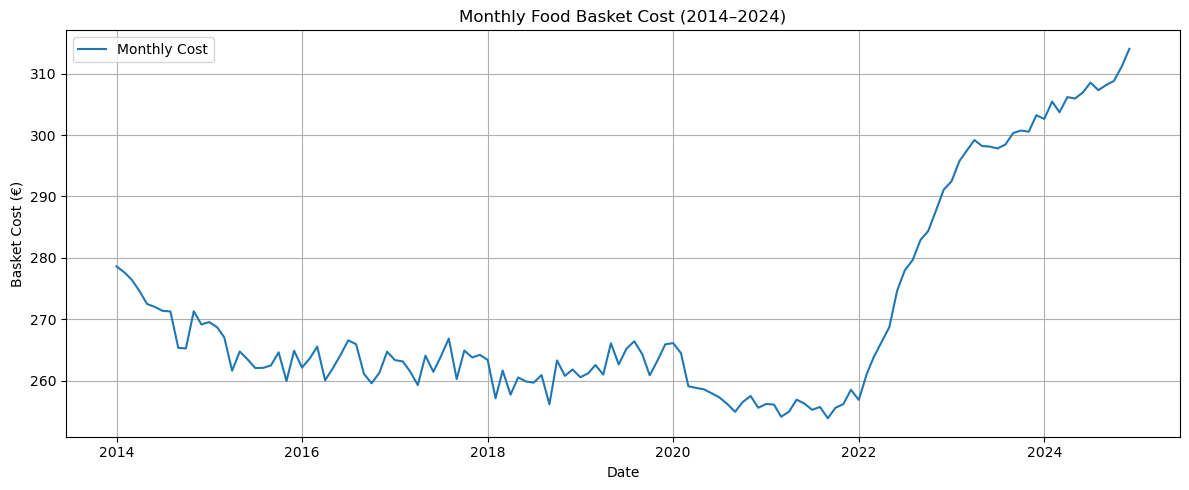

In [7]:
# Monthly Basket Cost Calculations.

# Create an empty DataFrame to store results for each item.
monthly_basket_costs = pd.DataFrame()

# Loop through each item in the manually defined food basket.
for item, quantity in food_basket.items():
    # Filter the food data for this item.
    df_item = food[food["Item"] == item].copy()
    
    # Multiply standardized price (€/kg or €/litre) by monthly quantity.
    df_item["Item_Total_Cost"] = df_item["Price_per_kg_or_litre"] * quantity
    
    # Keep only date and cost columns for aggregation.
    df_item = df_item[["Date", "Item_Total_Cost"]]
    
    # Rename for merging purposes (each item gets its own column first).
    df_item = df_item.rename(columns={"Item_Total_Cost": item})
    
    # Merge into the monthly_basket_costs DataFrame (outer join by Date).
    if monthly_basket_costs.empty:
        monthly_basket_costs = df_item
    else:
        monthly_basket_costs = pd.merge(monthly_basket_costs, df_item, on="Date", how="outer")

# Sum across all basket items to get total monthly basket cost
monthly_basket_costs["Basket_Cost_Euro"] = monthly_basket_costs.drop(columns=["Date"]).sum(axis=1)

# --------------------------------------------

#  Sum all item-level costs to get total monthly basket cost.

# Fill any missing prices with 0 (some items may be unavailable in some months).
monthly_basket_costs = monthly_basket_costs.fillna(0)

# Calculate total basket cost per month.
monthly_basket_costs["Basket_Cost_Euro"] = monthly_basket_costs.drop(columns="Date").sum(axis=1)

# Sort by date for clean time series.
monthly_basket_costs = monthly_basket_costs.sort_values("Date").reset_index(drop=True)

# Final structure.
monthly_basket_costs = monthly_basket_costs[["Date", "Basket_Cost_Euro"]]

# Preview the results.
print("Monthly Basket Cost (first 5 rows):")
print(monthly_basket_costs.head())

plt.figure(figsize=(12, 5)) # Sets the lineplot size.
plt.plot(monthly_basket_costs["Date"], monthly_basket_costs["Basket_Cost_Euro"], label="Monthly Cost") # Sets the plot content. 
plt.title("Monthly Food Basket Cost (2014–2024)") # Adds title to the plot/ 
plt.ylabel("Basket Cost (€)") # Sets y-label.
plt.xlabel("Date") # Sets x-label. 
plt.legend() 
plt.grid(True) # Sets true for grid in the background.  
plt.tight_layout() # Thights the layout. 
plt.show() # Displays the plot. 

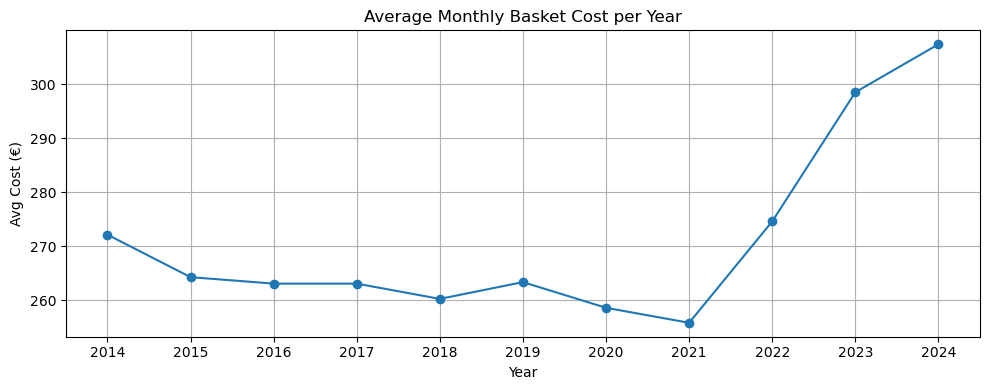

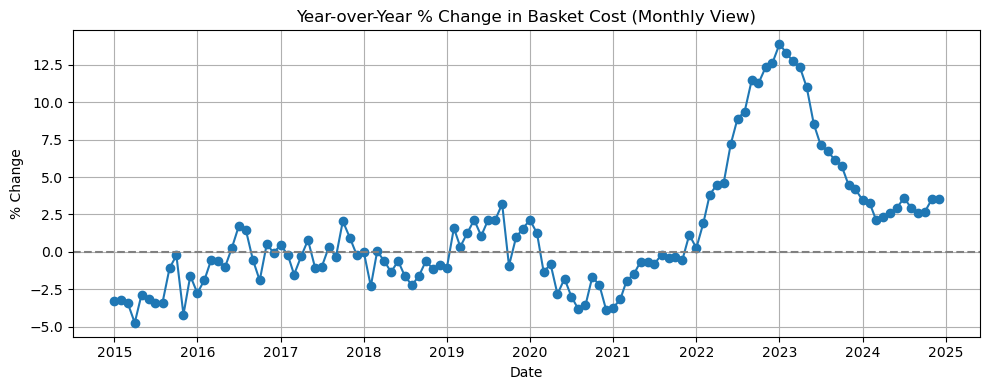

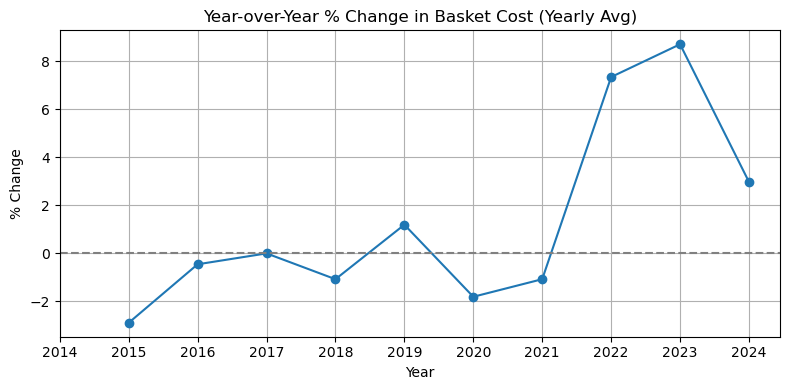

In [8]:
# Yearly Average Basket Cost

# Extract year from Date
monthly_basket_costs["Year"] = monthly_basket_costs["Date"].dt.year

# Group by year and compute mean.
yearly_avg_cost = (monthly_basket_costs.groupby("Year")["Basket_Cost_Euro"]
    .mean()
    .round(2)
    .reset_index())

# Line plot for yearly average cost
plt.figure(figsize=(10, 4)) # Sets the figure size.
plt.plot(yearly_avg_cost["Year"], yearly_avg_cost["Basket_Cost_Euro"], marker="o") # Contents of the plot with markers.
plt.title("Average Monthly Basket Cost per Year") # Adds title to the plot.
plt.xlabel("Year") # Set X-label.
plt.ylabel("Avg Cost (€)") # Set y-label.
plt.grid(True) # Add background grid.
plt.xticks(yearly_avg_cost["Year"])
plt.tight_layout()
plt.show() # Displays the plot.

# --------------------------------------------

# Year-over-Year % Change (Monthly)
monthly_basket_costs["YoY_Change"] = (monthly_basket_costs["Basket_Cost_Euro"].pct_change(12) * 100)

plt.figure(figsize=(10, 4)) # Sets the figure size.
plt.plot(monthly_basket_costs["Date"], monthly_basket_costs["YoY_Change"], marker="o") # Contents of the plot with markers.
plt.axhline(0, color="gray", linestyle="--")
plt.title("Year-over-Year % Change in Basket Cost (Monthly View)") # Adds title to the plot.
plt.xlabel("Date") # Set X-label.
plt.ylabel("% Change") # Set y-label.
plt.grid(True) # Add background grid.
plt.tight_layout()
plt.show() # Displays the plot.

# --------------------------------------------
# Year-over-Year % Change (Annual Avg)

# Calculate yearly YoY change using avg basket cost
yearly_avg_cost["YoY_Change"] = yearly_avg_cost["Basket_Cost_Euro"].pct_change() * 100

plt.figure(figsize=(8, 4)) # Sets the figure size.
plt.plot(yearly_avg_cost["Year"], yearly_avg_cost["YoY_Change"], marker="o") # Contents of the plot with markers.
plt.axhline(0, color="gray", linestyle="--") 
plt.title("Year-over-Year % Change in Basket Cost (Yearly Avg)") # Adds title to the plot.
plt.xlabel("Year") # Set X-label.
plt.ylabel("% Change") # Set y-label.
plt.grid(True) # Add background grid.
plt.xticks(yearly_avg_cost["Year"])
plt.tight_layout()
plt.show() # Displays the plot.

### Food Basket Cost & Inflation Trends (2014–2024)

#### Average (Monthly View) Basket Cost per Year
- From **2014 to 2021**, the average cost of a standard healthy food basket remained relatively stable, fluctuating between €128 and €135.
- Starting in **2022**, a sharp price increase began, peaking at over **€150/month in 2024**.
- This suggests a structural change in the cost of basic nutrition, not just a temporary fluctuation.

**Implication:**  
Households now pay **€25/month more** than they did pre-2022 to eat healthy — a significant burden, especially for low-income families.

---

#### Year-over-Year % Change in Basket Cost (Monthly View)
- Before 2021, food inflation was mild, with changes typically within ±2% YoY.
- Between **mid-2021 and mid-2023**, the basket saw extreme inflation spikes of **10–13%**, month-over-month compared to the previous year.
- Although rates are easing in 2024, monthly YoY change remains **consistently positive**, indicating elevated food prices are staying.

**Implication:**  
Inflation shocks were not brief — households suffered **over 24 months of rising food costs**, eroding purchasing power and making healthy eating harder to maintain.

---

#### Year-over-Year % Change in Basket Cost (Yearly Average)
- From **2014 to 2021**, most years saw flat or even negative YoY changes in average cost — strong price stability.
- In **2022 and 2023**, the index jumped by **7% and 9%** respectively — these are economically significant jumps.
- 2024 shows some recovery (~3% YoY), but prices remain well above the pre-inflation baseline.

**Implication:**  
This marks a **permanent shift in affordability**, not a temporary event. The economic system will need to **adjust structurally** to support households at this new cost level.

---

#### 📌 Summary of Impacts
- 🏷️ **Basket cost increased ~20%+ since 2021**.
- ⚠️ Monthly YoY spikes highlight **long-term inflation pressure**.
- 🛠️ **Policy response** is required to maintain nutrition quality of healthy food basket.

These trends reinforce the value of tracking **both absolute cost and relative affordability** over time — particularly during times of economic instability.

### Step 4: Affordability Ratio Calculation

After analysing the food basket prices the next phase will calculate how affordable the basket is over time by comparing the montlhy cost to the median household income.

#### Income Assumptions

Annual household income data was taken from the CSO (median income). To align it with monthly food prices:

- Annual values were divided evenly across 12 months.
- No seasonal or tax adjustments were applied.
- Income inequality or percentiles were not considered.

While this assumes a **uniform monthly distribution**, it provides a consistent baseline for comparing affordability over time.

#### Ratio Calculations

The **affordability ratio formula**:  Affordability Ratio = Basket *Cost* (€) / Monthly Household *Income* (€)

**How**:
1. Merge monthly basket cost with annual household income, converted to monthly.
2. Calculate the percentage of income required to buy the food basket each month.
3. Visualize how this ratio evolves over time.

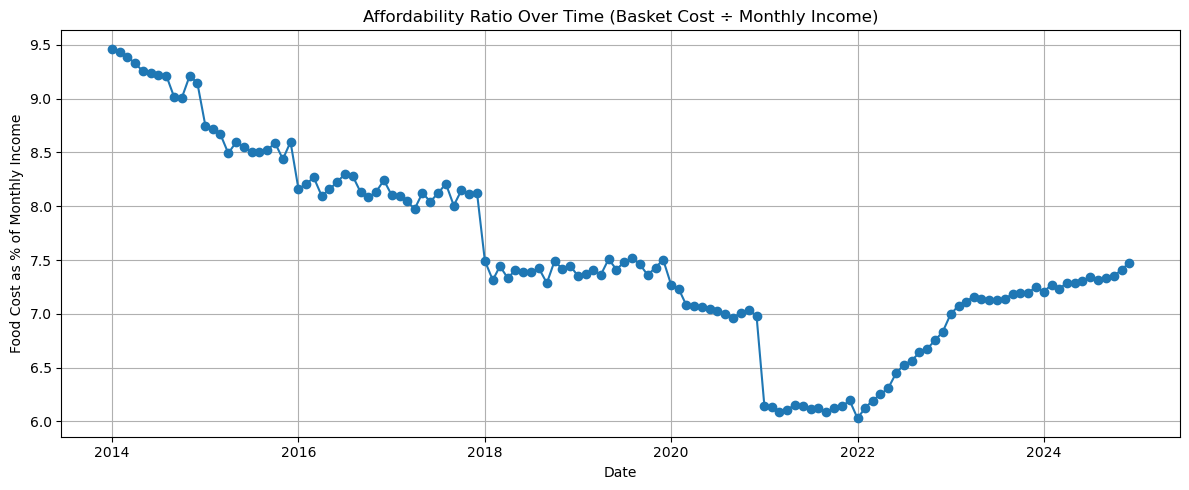

In [9]:
# Merge with Income & Affordability Ratio.

# The food prices had records up to may of 2025. Meanwhile, the availability of the income data was up to 2024 (date of the project), so the 
# following code will make sure that only the years that match are used.
# Filter food basket cost to years with income available.
max_income_year = income["Year"].max()
monthly_basket_costs = monthly_basket_costs[monthly_basket_costs["Date"].dt.year <= max_income_year]

# Create Year column for merge.
monthly_basket_costs["Year"] = monthly_basket_costs["Date"].dt.year

# Merge monthly food basket cost with yearly income data.
afford_df = pd.merge(monthly_basket_costs, income, on="Year", how="left")

# Calculate affordability ratio: % of monthly income spent on this basket.
afford_df["Affordability_Ratio"] = afford_df["Basket_Cost_Euro"] / afford_df["Monthly_Income"]

# Clean structure for plotting.
afford_df = afford_df[["Date", "Basket_Cost_Euro", "Monthly_Income", "Affordability_Ratio"]]

# --------------------------------------------
#  Plot the Affordability Ratio Over Time.

plt.figure(figsize=(12, 5)) # Sets the figure size. 
plt.plot(afford_df["Date"], afford_df["Affordability_Ratio"] * 100, marker='o')
plt.title("Affordability Ratio Over Time (Basket Cost ÷ Monthly Income)") # Adds the title. 
plt.ylabel("Food Cost as % of Monthly Income") # Y-label.
plt.xlabel("Date") # X-label. 
plt.grid(True) # Backgroubd grid.
plt.tight_layout() # Tight layout.
plt.show() # Displays the plot. 

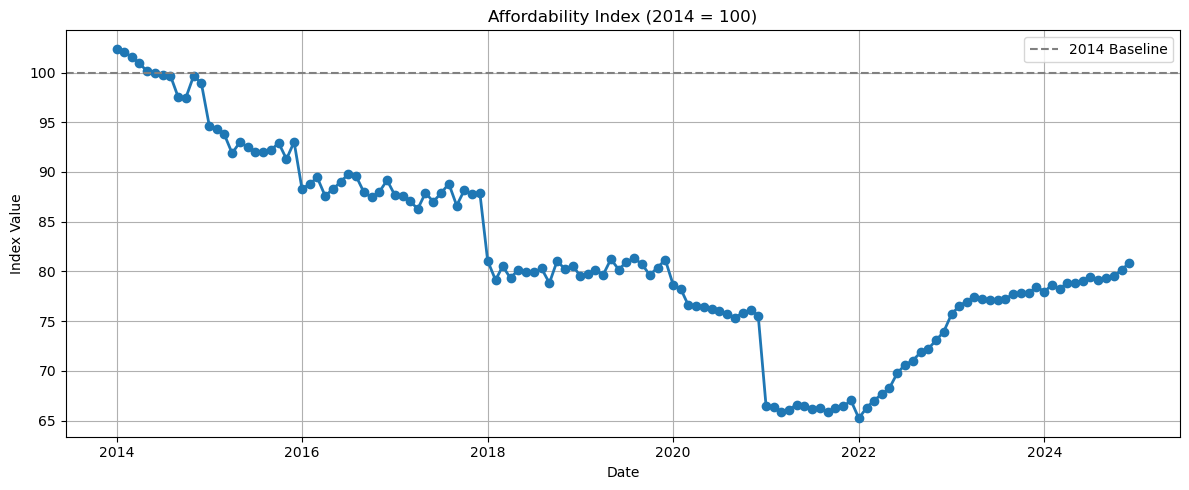

In [10]:
# Affordability Index (2014 baseline = 100)

# Reuse affordability ratio and baseline it to 2014 = 100.
# First, extract 2014 baseline.
base_ratio = afford_df[afford_df["Date"].dt.year == 2014]["Affordability_Ratio"].mean()

# Create index.
afford_df["Affordability_Index"] = (afford_df["Affordability_Ratio"] / base_ratio) * 100

# Plot Affordability Index Over Time
plt.figure(figsize=(12, 5)) # Sets figure size.
plt.plot(afford_df["Date"], afford_df["Affordability_Index"], marker="o", linewidth=2) # Sets content with markers. 
plt.axhline(100, color="gray", linestyle="--", label="2014 Baseline") # Adds a gray mark were the index is equal to 100%. 
plt.title("Affordability Index (2014 = 100)") # Add title to the figure. 
plt.ylabel("Index Value") # Add y-label.
plt.xlabel("Date") # Add x-label. 
plt.grid(True) # Add background grid. 
plt.legend()
plt.tight_layout() # Add legend. 
plt.show() # Shows the lineplot. 

### Affordability Analysis (Ratio & Index)

#### 💶 What is Measured:

- Monthly cost of the standard food basket is compared against household income, calculating:

**Affordability Ratio** = Basket Cost ÷ Monthly Income → Represents % of income needed to purchase the food basket

**Affordability Index (2014 = 100)** = Relative change in affordability since 2014 → Allows for easier year-over-year comparison

#### Key Findings:

#### 1. Affordability Ratio Over Time

- From 2014 to 2021, food became **more affordable**, with the basket cost falling from **~4.7% to 3.1%** of monthly income.
- Starting in 2022, affordability declined: by 2024, the same food basket now costs **~3.75%** of monthly income.
- This shows that **food inflation outpaced wage growth**, reversing nearly a decade of affordability progress.
- These affordability curves directly match the earlier basket cost and YoY inflation analysis.
  
#### 2. Affordability Index (2014 = 100)

- The index improved until 2021, reaching **a peak of ~135** (meaning food was 35% more affordable than in 2014).  
- At the end of 2022, the index plummeted — reaching a low of ~65.
- By 2024, there is **partial recovery** (~81), but affordability remains well below pre-inflation levels.


#### 🧠 Policy Implications

- Ireland **lost a decade of food affordability gains** in just 2 years.
- Even though incomes are rising, **price shocks are sticking**, not reversing.
- Without intervention (e.g. subsidies, income adjustment, price caps), this creates a risk of **long-term damage to heathly diets** — especially for low-income households.


### 📘 Conclusion

This analysis tracked the cost and affordability of a standard healthy food basket in Ireland from 2014 to 2024. The key findings were:

- 🧺 **Basket cost increased by over 20%**, with the sharpest rise post-2021
- 📈 **Food inflation outpaced income growth**, particularly during 2022–2023
- 📉 The **affordability index dropped by ~35%** before partially recovering
- 💰 As of 2024, food is still **~20% less affordable** than at its peak in 2021

This has direct implications for economic policy, food subsidies, and public health — especially for vulnerable populations.

---

### ⚠️ Limitations

- 🗂️ **Food basket is simplified** and may not reflect all nutritional needs or real-life diets.
- 📉 **Income data is median-level only**; it does not account for income distribution or inequality.
- 📆 **Seasonal pricing** and promotions were not considered.
- 📊 Data assumes clean linear interpolation between annual income points (monthly incomes are estimated)

---

#### 🍽️ A Deeper Look: Not All Foods Are Affected Equally.

While the overall affordability trend is clear, **not all food types experienced the same price pressure**.

To better understand the drivers of the affordability shift, the behaviour of different **nutritional categories** — Healthy, Neutral, and Unhealthy — across the 2014–2024 period are explored.

This breakdown helps identify which types of foods are contributing most to the decline in affordability, and whether inflation is disproportionately affecting **nutritious diets**.

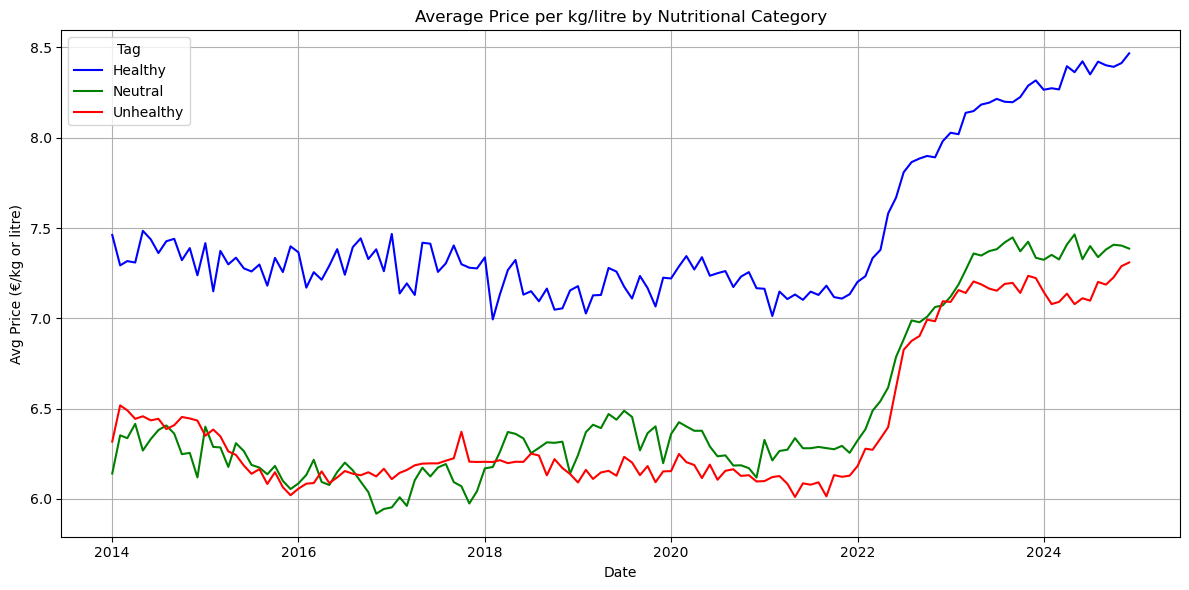

In [11]:
# 📈 Average Price per kg/litre by Tag (Healthy, Unhealthy, Neutral)

# Group and aggregate monthly average price per group.
group_trends = (
    food.groupby(["Date", "Tag"])["Price_per_kg_or_litre"]
    .mean()
    .reset_index())

# Pivot for plotting.
group_pivot = group_trends.pivot(index="Date", columns="Tag", values="Price_per_kg_or_litre")

# Define color mapping (same as previous notebooks).
color_map = {
    "Healthy": "blue",
    "Neutral": "green",
    "Unhealthy": "red"}

# Plot trends.
plt.figure(figsize=(12, 6)) # Sets figure size 
for tag in group_pivot.columns: # Sets function for the plot. 
    plt.plot(group_pivot.index, group_pivot[tag], label=tag, color=color_map.get(tag, "gray")) # contents for the plot + color map. 
plt.title("Average Price per kg/litre by Nutritional Category") # Add title to the plot. 
plt.ylabel("Avg Price (€/kg or litre)") # Set y-label. 
plt.xlabel("Date") # Set x-label.
plt.grid(True) # Add background grid. 
plt.legend(title="Tag") # Adds legend to identify each tag. 
plt.tight_layout() 
plt.show() # Displays the plot. 

### 🍽️ Nutritional Category Trends & Implications

The chart above shows the **average price per kg/litre** over time for three nutritional categories: **Healthy, Neutral, and Unhealthy**.

#### 📈 Key Observations:
- **Healthy food prices** remained relatively stable until early 2022, after which they surged by over 15% through 2024.
- **Neutral foods** (e.g. bread, pasta) also increased sharply but began recovering slightly after 2023.
- **Unhealthy foods** showed the slowest price growth and remained more affordable across the entire period.

#### 🧠 Implications:
- The affordability of a **healthy diet** is being disproportionately impacted by inflation, potentially widening health disparities.
- Consumers may **substitute away from healthy items** toward cheaper, lower-nutrient options when prices rise — especially under income pressure.
- This supports the need for **policy interventions** that protect access to healthy foods, such as:
  - Direct subsidies for fruit, vegetables, dairy.
  - Reducing VAT on healthy staples.
  - Monitoring food inflation *by nutritional group*.

This chart adds vital context to the affordability index by showing that the **quality of diet**, not just the cost, is under economic pressure.

---

#### 🏛️ Policy Recommendations

Based on the affordability analysis and observed price trends:

1. **Subsidize healthy essentials** (milk, vegetables, whole grains) to maintain nutrition access.
2. **Monitor food inflation** in essential categories, not just headline CPI.
3. Consider **temporary vouchers** or support schemes for low-income households during inflation spikes.

These interventions could protect access to healthy diets while addressing rising cost-of-living pressure.

---

#### 🛒 Consumer Guidance:
- Favor seasonal fruits and vegetables to lower monthly basket costs.
- Diversify proteins: eggs remain cheaper for alternatives to meat.
- Track sales and loyalty programs for core staples (e.g., bread, dairy).
  
---

#### ⚠️ Limitations

- The basket is a **simplified model** and may not capture full nutrient diversity (e.g. omega-3s, micronutrients).
- **Household income** is modeled at the median level, evenly distributed monthly.
- The analysis **does not adjust for household size**, income inequality, or regional food price variation.
- **Seasonality, brand variety, and promotions** were not considered.

In [12]:
afford_df.head()

,Date,Basket_Cost_Euro,Monthly_Income,Affordability_Ratio,Affordability_Index
0,2014-01-01,278.604312,2943.916667,0.094637,102.383871
1,2014-02-01,277.619386,2943.916667,0.094303,102.021923
2,2014-03-01,276.471006,2943.916667,0.093913,101.599906
3,2014-04-01,274.608411,2943.916667,0.093280,100.915424
4,2014-05-01,272.484095,2943.916667,0.092558,100.134762


In [13]:
afford_df.to_csv("affordability_final.csv", index=False)